# Import

In [1]:
import numpy as np
from scipy.linalg import toeplitz
from sys import getsizeof
from timeit import default_timer as time
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from numpy.linalg import inv
import functions_eq_mag as fc
import functions_fatiando as ft
import fourier_continuation as fc_c
import pickle as pickle
%matplotlib inline

# Observation and Equivalent layer grids

In [2]:
# Create a regular grid at 0m height
area = [-5000., 5000., -4000., 4000.]
shape = (50, 50)
N = shape[0]*shape[1]
xi, yi, zi = ft.gridder_regular(area, shape, z=-900.)
#x_perc = (xi[shape[1]]-xi[0])*0.10
#y_perc = (yi[1]-yi[0])*0.10
#z_perc = (-zi[0])*0.10
#np.random.seed(10)
#noise_x = np.random.normal(0, x_perc, len(xi))
#noise_y = np.random.normal(0, y_perc, len(xi))
#noise_z = np.random.normal(0, z_perc, len(zi))
#xi = xi + noise_x
#yi = yi + noise_y
#zi = zi + noise_z

xi_plot, yi_plot, = xi/1000, yi/1000

# Equivalent Layer
areaj = [-5000., 5000., -4000., 4000.]
shapej = (50, 50)
Nj = shapej[0]*shapej[1]
xj, yj, zj = ft.gridder_regular(areaj, shapej, z=50)

## Create the model

In [3]:
# Model
verts1 = [[-3500, -3000], [-2000, -3000], [-2000, 3000], [-3500, 3000]]
#verts2 = [[4000, -3000], [4500, -2500], [0, 3500], [-500, 3000]]
model_prism = [ft.mesher_PolygonalPrism(verts1, 900., 1500., props={'magnetization':[2,2,2]})]

R1 = 1000 #Radius 1
R2 = 750 #Radius 2
xc1, yc1, zc1 = 3000., -2000., 2000. #Center of sphere 1
xc2, yc2, zc2 = 1000., 2500., 1800. #Center of sphere 2
model_sphere = [ft.mesher_Sphere(xc1, yc1, zc1, R1, props={'magnetization':[2,2,2]}),
                ft.mesher_Sphere(xc2, yc2, zc2, R2, props={'magnetization':[2,2,2]})]

print (ft.utils_vec2ang([2,2,2]))

[3.4641016151377544, 35.264389682754654, 45.0]


In [4]:
# Magnetic Configuration, inc 10, dec 37
inc0 = np.deg2rad(3.46)
dec0 = np.deg2rad(35.26)
inc = np.deg2rad(3.46)
dec = np.deg2rad(35.26)

F = np.array([np.cos(inc0)*np.cos(dec0), np.cos(inc0)*np.sin(dec0), np.sin(inc0)])
h = np.array([np.cos(inc)*np.cos(dec), np.cos(inc)*np.sin(dec), np.sin(inc)])

In [5]:
data = []
delta_g = []
tf_prism = ft.polyprism_tf(xi, yi, zi, model_prism, np.rad2deg(inc0), np.rad2deg(dec0))
tf_sphere = ft.sphere_tf(xi, yi, zi, model_sphere, np.rad2deg(inc0), np.rad2deg(dec0))
dobs_0 = tf_prism + tf_sphere
data.append(dobs_0)
noise = np.linspace(1,10,20)/100
seed = np.linspace(1,20,20, dtype='int64')
norm_g = np.linalg.norm(dobs_0)
for i in range(len(noise)):
    dobs = ft.utils_contaminate(dobs_0, noise[i], seed=seed[i], percent=True)
    norm_gl = np.linalg.norm(dobs-dobs_0)/norm_g
    data.append(dobs)
    delta_g.append(norm_gl)

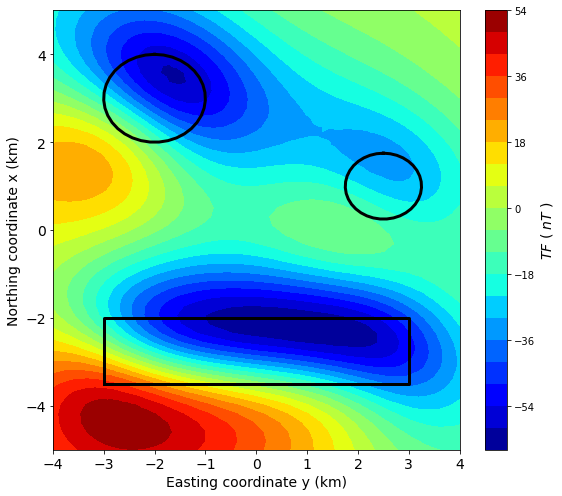

In [6]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig = plt.figure(figsize=(8,7))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,data[0],22,cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
plt.savefig('../../manuscript/Fig/synthetic_mag.png', dpi=300)

# Classic Forward Problem Construction - MAG

In [7]:
# Calculo da matriz de sensibilidade
delta_p_classical = []
p_0, tf_c = fc.classic_mag(xi,yi,zi,zj,F,h,N,data[0])
norm_p_0 = np.linalg.norm(p_0)
for i in range(len(data)-1):
    p, tf_c = fc.classic_mag(xi,yi,zi,zj,F,h,N,data[i+1])
    norm_pl = np.linalg.norm(p-p_0)/norm_p_0
    delta_p_classical.append(norm_pl)

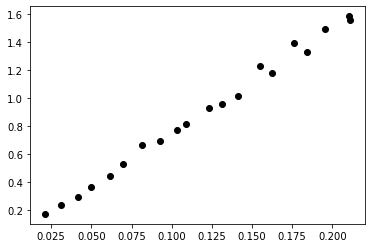

In [8]:
plt.plot(delta_g,delta_p_classical, 'ko')

### BCCB  matrix-vector product with Linear CGLS implementation

In [9]:
delta_p_BCCB = []
itmax = 50
p_bccb_0, tf_bccb = fc.cgls_eq_bccb_mag(xi,yi,zi,zj,shape,data[0],F,h,itmax)
norm_p_bccb_0 = np.linalg.norm(p_bccb_0)
for i in range(len(data)-1):
    p_bccb, tf_bccb = fc.cgls_eq_bccb_mag(xi,yi,zi,zj,shape,data[i+1],F,h,itmax)
    norm_p_c = np.linalg.norm(p_bccb-p_bccb_0)/norm_p_bccb_0
    delta_p_BCCB.append(norm_p_c)

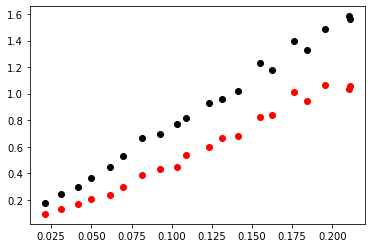

In [10]:
plt.plot(delta_g,delta_p_classical, 'ko')
plt.plot(delta_g,delta_p_BCCB, 'ro')

## Deconvolution

In [11]:
delta_p_dec = []
rho_c_0_dec, gzp_dec = fc.fast_eq_dec_mag(xi,yi,zi,zj,F,h,N,shape,data[0])
norm_rho_c_0_dec = np.linalg.norm(rho_c_0_dec)
for i in range(len(data)-1):
    rho_c_dec, tf_dec = fc.fast_eq_dec_mag(xi,yi,zi,zj,F,h,N,shape,data[i+1])
    norm_rho_c_dec = np.linalg.norm(rho_c_dec-rho_c_0_dec)/norm_rho_c_0_dec
    delta_p_dec.append(norm_rho_c_dec)

## Deconvolution wiith Wiener stabilization

In [12]:
# Regularization factor of Wiener deconvolution
a, b, c = -10, -13, -16
mu0 = 10**(a)
mu1 = 10**(b)
mu2 = 10**(c)

delta_p_dec_wiener0 = []
delta_p_dec_wiener1 = []
delta_p_dec_wiener2 = []

rho_c_0_dec_wiener, tf_0_dec_wiener = fc.fast_eq_dec_mag_wiener(xi,yi,zi,zj,F,h,N,shape,data[0],mu0)
norm_rho_c_0_dec_wiener = np.linalg.norm(rho_c_0_dec_wiener)

rho_c_1_dec_wiener, tf_1_dec_wiener = fc.fast_eq_dec_mag_wiener(xi,yi,zi,zj,F,h,N,shape,data[0],mu1)
norm_rho_c_1_dec_wiener = np.linalg.norm(rho_c_1_dec_wiener)

rho_c_2_dec_wiener, tf_2_dec_wiener = fc.fast_eq_dec_mag_wiener(xi,yi,zi,zj,F,h,N,shape,data[0],mu2)
norm_rho_c_2_dec_wiener = np.linalg.norm(rho_c_2_dec_wiener)

for j in range(len(data)-1):
    
    rho_c_dec_wiener0, tf_dec_wiener0 = fc.fast_eq_dec_mag_wiener(xi,yi,zi,zj,F,h,N,shape,data[j+1],mu0)
    norm_rho_c_dec_wiener0 = np.linalg.norm(rho_c_dec_wiener0-rho_c_0_dec_wiener)/norm_rho_c_0_dec_wiener
    delta_p_dec_wiener0.append(norm_rho_c_dec_wiener0)
    
    rho_c_dec_wiener1, tf_dec_wiener1 = fc.fast_eq_dec_mag_wiener(xi,yi,zi,zj,F,h,N,shape,data[j+1],mu1)
    norm_rho_c_dec_wiener1 = np.linalg.norm(rho_c_dec_wiener1-rho_c_1_dec_wiener)/norm_rho_c_1_dec_wiener
    delta_p_dec_wiener1.append(norm_rho_c_dec_wiener1)
    
    rho_c_dec_wiener2, tf_dec_wiener2 = fc.fast_eq_dec_mag_wiener(xi,yi,zi,zj,F,h,N,shape,data[j+1],mu2)
    norm_rho_c_dec_wiener2 = np.linalg.norm(rho_c_dec_wiener2-rho_c_2_dec_wiener)/norm_rho_c_2_dec_wiener
    delta_p_dec_wiener2.append(norm_rho_c_dec_wiener2)

## Straight line fits

In [13]:
#coe0 = np.polyfit(delta_g, delta_p_classical_0, 1)
#poly1d_fn0 = np.poly1d(coe0)

coe = np.polyfit(delta_g, delta_p_classical, 1)
poly1d_fn = np.poly1d(coe)

coe2 = np.polyfit(delta_g, delta_p_BCCB, 1)
poly1d_fn2 = np.poly1d(coe2)

coe3 = np.polyfit(delta_g, delta_p_dec, 1)
poly1d_fn3 = np.poly1d(coe3)

coe4 = np.polyfit(delta_g, delta_p_dec_wiener0, 1)
poly1d_fn4 = np.poly1d(coe4)

coe5 = np.polyfit(delta_g, delta_p_dec_wiener1, 1)
poly1d_fn5 = np.poly1d(coe5)

coe6 = np.polyfit(delta_g, delta_p_dec_wiener2, 1)
poly1d_fn6 = np.poly1d(coe6)

## Figure plots

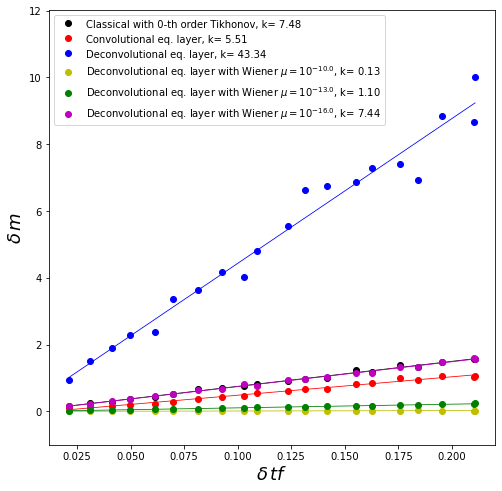

In [14]:
fig=plt.figure(figsize=(8,8))
fig.patch.set_facecolor('xkcd:white')
plt.plot(delta_g,delta_p_classical, 'ko', label='Classical with 0-th order Tikhonov, k= %.2f' % (coe[0]))
plt.plot(delta_g,poly1d_fn(delta_g), 'k-', linewidth=0.8)
plt.plot(delta_g,delta_p_BCCB, 'ro', label='Convolutional eq. layer, k= %.2f' % (coe2[0]))
plt.plot(delta_g,poly1d_fn2(delta_g), 'r-', linewidth=0.8)
plt.plot(delta_g,delta_p_dec, 'bo', label='Deconvolutional eq. layer, k= %.2f' % (coe3[0]))
plt.plot(delta_g,poly1d_fn3(delta_g), 'b-', linewidth=0.8)
plt.plot(delta_g,delta_p_dec_wiener0, 'yo', label='Deconvolutional eq. layer with Wiener $\mu = 10^{%.1f}$, k= %.2f' % (a, coe4[0]))
plt.plot(delta_g,poly1d_fn4(delta_g), 'y-', linewidth=0.8)
plt.plot(delta_g,delta_p_dec_wiener1, 'go', label='Deconvolutional eq. layer with Wiener $\mu = 10^{%.1f}$, k= %.2f' % (b, coe5[0]))
plt.plot(delta_g,poly1d_fn5(delta_g), 'g-', linewidth=0.8)
plt.plot(delta_g,delta_p_dec_wiener2, 'mo', label='Deconvolutional eq. layer with Wiener $\mu = 10^{%.1f}$, k= %.2f' % (c, coe6[0]))
plt.plot(delta_g,poly1d_fn6(delta_g), 'm-', linewidth=0.8)
plt.ylim(np.min(delta_p_dec_wiener0)-1,np.max(delta_p_dec)+2)
plt.xlabel('$\delta \, tf$', fontsize=18)
plt.ylabel('$\delta \, m$', fontsize=18)
plt.legend(loc='upper left', fontsize=10)
plt.savefig('../../manuscript/Fig/stability_mag.png', dpi=300)

## Fit comparison

In [15]:
#A = fc.sensibility_matrix(xi,yi,zi,zj,F,h,N)

#tf_classic = np.dot(A,p)
#tf_bccb = np.dot(A,p_bccb)
#tf_dec = np.dot(A,rho_c_dec)
#tf_dec_wiener0 = np.dot(A,rho_c_dec_wiener0)
#tf_dec_wiener1 = np.dot(A,rho_c_dec_wiener1)
#tf_dec_wiener2 = np.dot(A,rho_c_dec_wiener2)

In [16]:
scale_max = np.max(tf_c)
scale_min = np.min(tf_c)

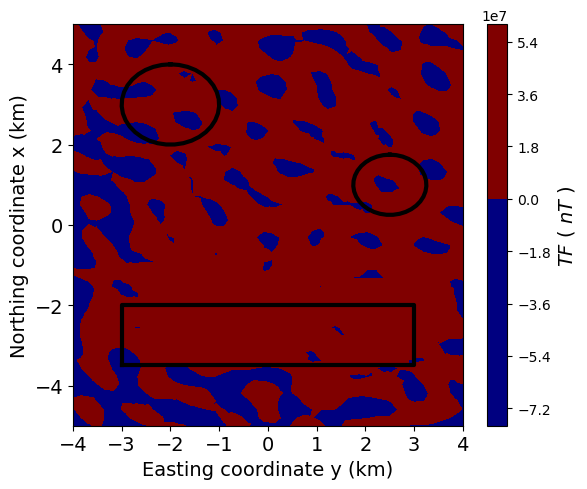

In [20]:
fig = plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,p_bccb,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/model_mag_noise.png', dpi=300)

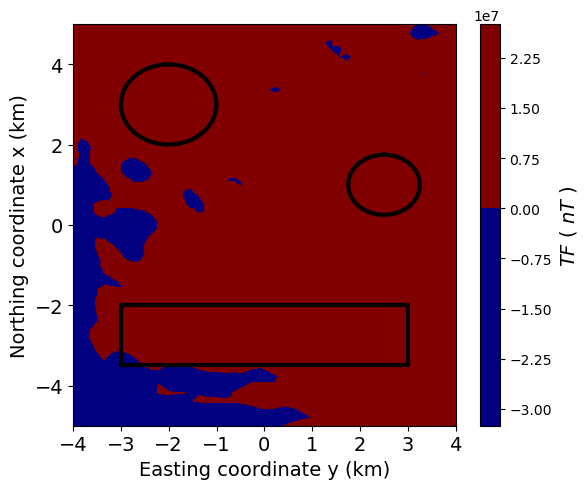

In [21]:
fig = plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,rho_c_dec_wiener1,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/model_mag_noise.png', dpi=300)

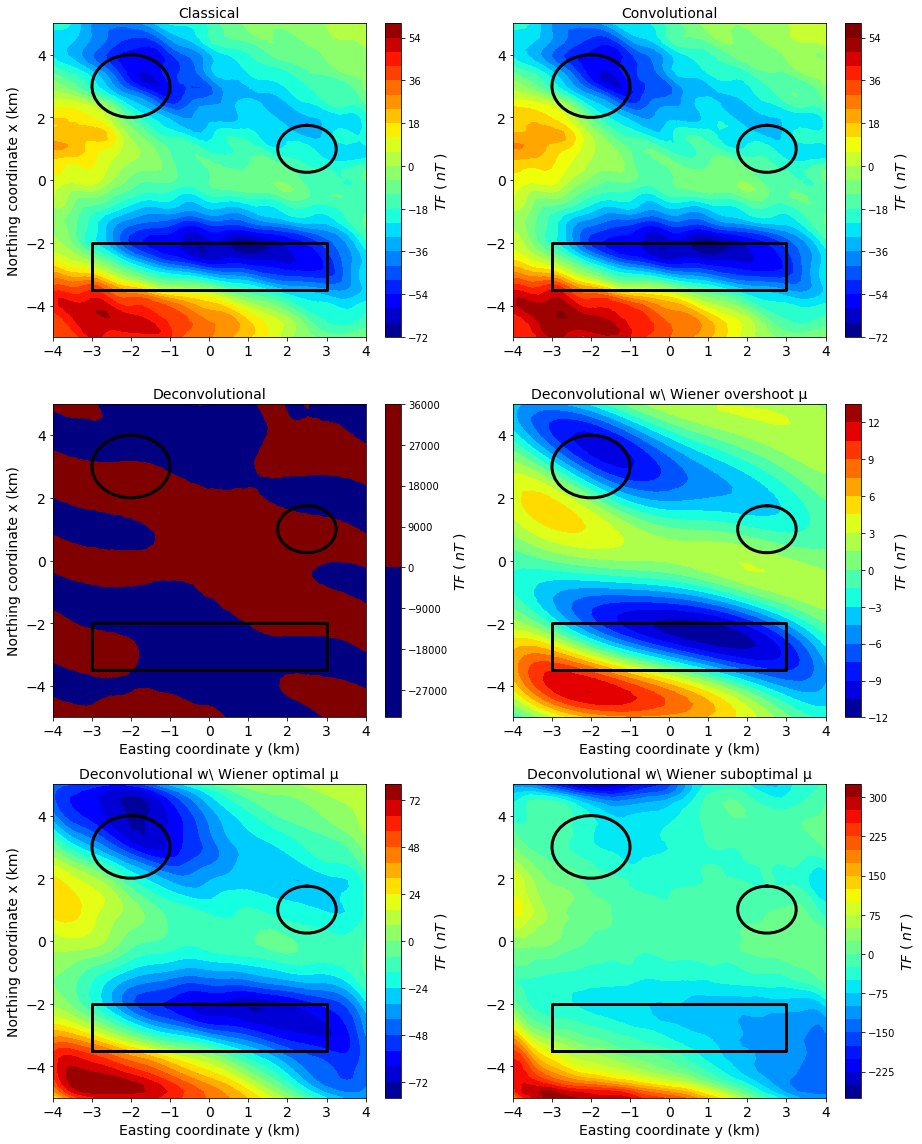

In [18]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig = plt.figure(figsize=(13,16))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(321)
plt.title('Classical', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_c,22,cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(322)
plt.title('Convolutional', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_bccb,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(323)
plt.title('Deconvolutional', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_dec,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(324)
plt.title('Deconvolutional w\ Wiener overshoot \u03BC', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_dec_wiener0,22,cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(325)
plt.title('Deconvolutional w\ Wiener optimal \u03BC', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_dec_wiener1,22,cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(326)
plt.title('Deconvolutional w\ Wiener suboptimal \u03BC', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_dec_wiener2,22,cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.tight_layout()
plt.savefig('../../manuscript/Fig/stability_mag_comparison.png', dpi=300)

In [23]:
print (np.mean(np.abs(data[-1]-tf_c)), ('(Classical method)'))
print (np.mean(np.abs(data[-1]-tf_bccb)), ('(CG BTTB method)'))
print (np.mean(np.abs(data[-1]-tf_dec)), ('(Deconvolutional method)'))
print (np.mean(np.abs(data[-1]-tf_dec_wiener0)), ('(Deconvolutional w\ Wiener overshoot \u03BC method)'))
print (np.mean(np.abs(data[-1]-tf_dec_wiener1)), ('(Deconvolutional w\ Wiener optimal \u03BC method)'))
print (np.mean(np.abs(data[-1]-tf_dec_wiener2)), ('(Deconvolutional w\ Wiener suboptimal \u03BC method)'))
print ()
print (np.std(np.abs(data[-1]-tf_c)), ('(Classical method)'))
print (np.std(np.abs(data[-1]-tf_bccb)), ('(CG BTTB method)'))
print (np.std(np.abs(data[-1]-tf_dec)), ('(Deconvolutional method)'))
print (np.std(np.abs(data[-1]-tf_dec_wiener0)), ('(Deconvolutional w\ Wiener overshoot \u03BC method)'))
print (np.std(np.abs(data[-1]-tf_dec_wiener1)), ('(Deconvolutional w\ Wiener optimal \u03BC method)'))
print (np.std(np.abs(data[-1]-tf_dec_wiener2)), ('(Deconvolutional w\ Wiener suboptimal \u03BC method)'))

4.71700586977892 (Classical method)
4.791561788289162 (CG BTTB method)
2761.170136908849 (Deconvolutional method)
23.06442216727077 (Deconvolutional w\ Wiener overshoot μ method)
8.860326967314595 (Deconvolutional w\ Wiener optimal μ method)
33.83142137645327 (Deconvolutional w\ Wiener suboptimal μ method)

3.571868619217408 (Classical method)
3.6420538498453263 (CG BTTB method)
4507.745135864884 (Deconvolutional method)
14.232818621809827 (Deconvolutional w\ Wiener overshoot μ method)
7.445085208152109 (Deconvolutional w\ Wiener optimal μ method)
47.8175518946965 (Deconvolutional w\ Wiener suboptimal μ method)


## Plots for the Frontiers Paper

### Predicted classical (equivalent layer for the most noisy data)

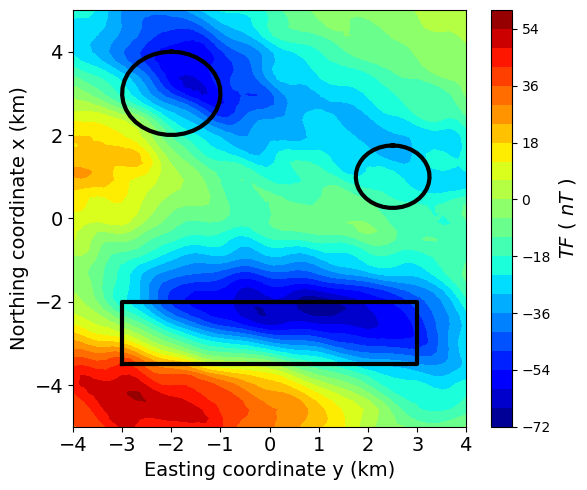

In [24]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot, tf_c, 22, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/predicted_tf_classic.png', dpi=300)

### Predicted CG BTTB (equivalent layer for the most noisy data)

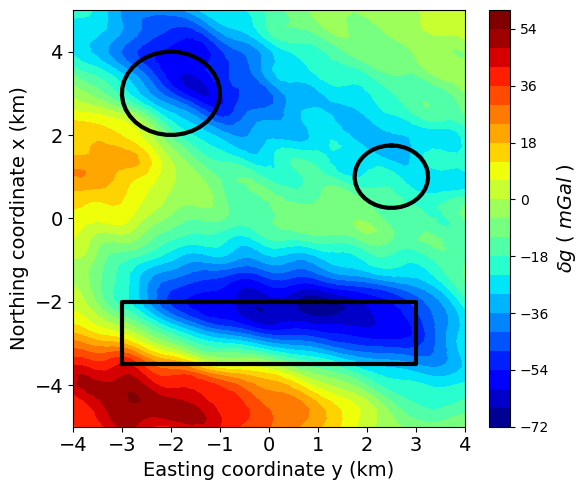

In [25]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot, tf_bccb, 22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/predicted_tf_bttb.png', dpi=300)

### Predicted deconvolutional (equivalent layer for the most noisy data)

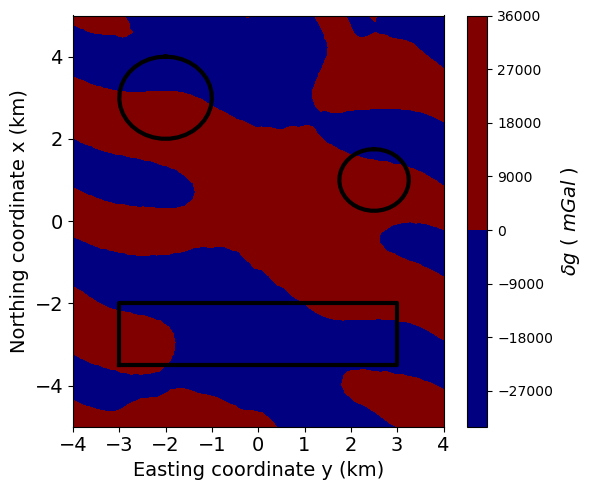

In [26]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,tf_dec, 22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/predicted_tf_dec.png', dpi=300)

### Predicted deconvolutional w\ Wiener overshoot $\mu$ (equivalent layer for the most noisy data)

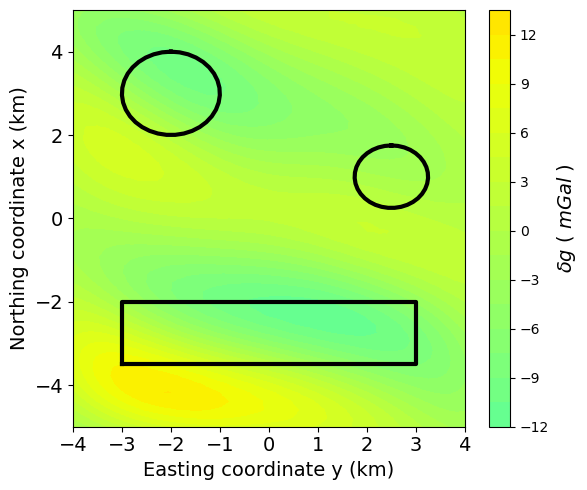

In [27]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,tf_dec_wiener0, 22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/predicted_tf_dec_wiener0.png', dpi=300)

### Predicted deconvolutional w\ Wiener optimal $\mu$ (equivalent layer for the most noisy data)

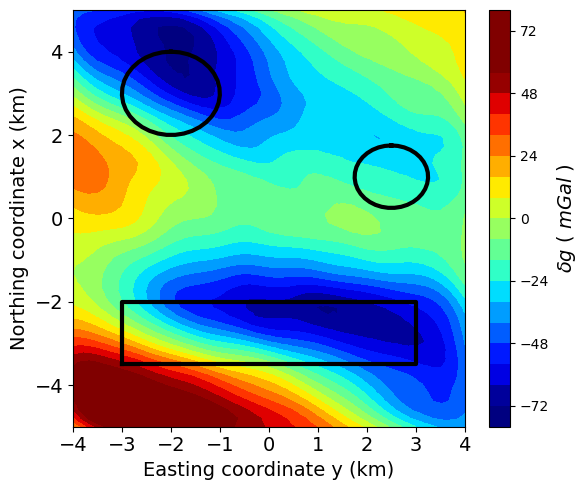

In [28]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,tf_dec_wiener1, 22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/predicted_tf_dec_wiener1.png', dpi=300)

### Predicted deconvolutional w\ Wiener suboptimal $\mu$ (equivalent layer for the most noisy data)

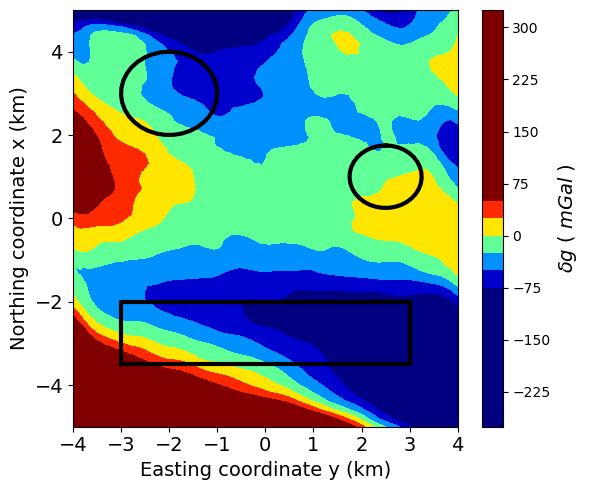

In [29]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,tf_dec_wiener2, 22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$\delta g$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('../../manuscript/Fig/predicted_tf_dec_wiener2.png', dpi=300)

In [7]:
hxx,hxy,hxz,hyy,hyz,hzz = fc.h_bttb_mag(xi,yi,zi,zj,F,h,shape)
cev_mag = fc.ones_cev_mag(hxx,hxy,hxz,hyy,hyz,hzz,shape,N,F,h)

In [8]:
cev_mag2 = fc.ones_cev_mag2(hxx,hxy,hxz,hyy,hyz,hzz,shape,N,F,h)

In [13]:
np.allclose(cev_mag, cev_mag2, atol=1e-30)

True